# Project 1
## AutoML
Team 3: Marko Lillemägi, Paula Marie Loopere, Mirjam Jesmin

# Setup

In [ ]:
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.cluster import KMeans
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier

from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, VotingRegressor, ExtraTreesRegressor
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from random import sample

import xgboost as xgb
import lightgbm as lgb

from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score, roc_curve,confusion_matrix,accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay

from statsmodels.stats.contingency_tables import mcnemar

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


# Data

In [ ]:
# Load the iris dataset
data = datasets.load_iris()
#data

In [ ]:
X = data.data
y = data.target
random_state = 0

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)


## New data


In [6]:
df = pd.read_csv('train.csv').sample(frac=0.2, random_state=0)

df = df.dropna(subset=['Credit_Score'])
df = df.drop(['ID','Name','SSN','Customer_ID'], axis=1)

# Function to extract years and months
def extract_years_months(duration):
    if duration is None or pd.isna(duration):
        return pd.Series([None, None])
    parts = duration.split(' ')
    years = int(parts[0])
    months = int(parts[3])
    return pd.Series([years, months])

# Apply the function to the DataFrame
df[['Years', 'Months']] = df['Credit_History_Age'].apply(extract_years_months)



label_mapping = {'Good': 2, 'Standard': 1, 'Poor':0}
df['Credit_Score'] = df['Credit_Score'].map(label_mapping)


X = df.drop(['Credit_Score'], axis=1)
y = df['Credit_Score']

categorical_features = X.select_dtypes(include=['object']).columns



for col in categorical_features:
    X[col] = X[col].astype('category').cat.codes

X.fillna(X.mean(), inplace=True)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

X_train_copy = X_train.copy()
X_test_copy = X_test.copy()



X_test = X_test.drop(['Years', 'Months'], axis=1)
X_train = X_train.drop(['Years', 'Months'], axis=1)

X_train_copy = X_train_copy.drop(['Credit_History_Age'], axis=1)
X_test_copy = X_test_copy.drop(['Credit_History_Age'], axis=1)
# Convert all categorical features to integers automatically


<ipython-input-6-10be724a9adf>:1: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/sample_data/train.csv').sample(frac=0.2, random_state=0)


In [7]:
X_train_copy.columns

Index(['Month', 'Age', 'Occupation', 'Annual_Income', 'Monthly_Inhand_Salary',
       'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan',
       'Type_of_Loan', 'Delay_from_due_date', 'Num_of_Delayed_Payment',
       'Changed_Credit_Limit', 'Num_Credit_Inquiries', 'Credit_Mix',
       'Outstanding_Debt', 'Credit_Utilization_Ratio', 'Payment_of_Min_Amount',
       'Total_EMI_per_month', 'Amount_invested_monthly', 'Payment_Behaviour',
       'Monthly_Balance', 'Years', 'Months'],
      dtype='object')

In [8]:
X_train.columns

Index(['Month', 'Age', 'Occupation', 'Annual_Income', 'Monthly_Inhand_Salary',
       'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan',
       'Type_of_Loan', 'Delay_from_due_date', 'Num_of_Delayed_Payment',
       'Changed_Credit_Limit', 'Num_Credit_Inquiries', 'Credit_Mix',
       'Outstanding_Debt', 'Credit_Utilization_Ratio', 'Credit_History_Age',
       'Payment_of_Min_Amount', 'Total_EMI_per_month',
       'Amount_invested_monthly', 'Payment_Behaviour', 'Monthly_Balance'],
      dtype='object')

# Step 1: Baseline

In [9]:
classifiers = {
    "Logistic Regression": LogisticRegression(),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "XGBoost": XGBClassifier(),
    "LDA": LinearDiscriminantAnalysis(),
    "SVM": SVC(),
    "Gaussian Naive Bayes": GaussianNB(),
    "Neural Network MLP Classifier": MLPClassifier(),
    "Kmeans for Clustering": KMeans(),
    "LightGBM": LGBMClassifier(),
    "VotingClassifier": VotingClassifier(estimators=[('lr', LogisticRegression()), ('dt', DecisionTreeClassifier()), ('svc', SVC())]),
    "Extra Trees": ExtraTreesClassifier()}

regressors = {
    "Linear Regression": LinearRegression(),
    "KNN": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor(),
    "AdaBoost": AdaBoostRegressor(),
    "XGBoost": xgb.XGBRegressor(),
    "SVM ": SVR(),
    "MLP Regressor (Neural Network)": MLPRegressor(),

    "LightGBM": lgb.LGBMRegressor(),
    "Voting Regressor": VotingRegressor(estimators=[
        ('lr', LinearRegression()),
        ('dt', DecisionTreeRegressor()),
        ('svr', SVR())
    ]),
    "Extra Trees": ExtraTreesRegressor(),
    "Lasso": Lasso(),
    "Ridge": Ridge()}

scores = {}

for name, clf in classifiers.items():
#for name, clf in regressors.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    scores[name] = round(accuracy,4)

    #rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    #scores[name] = round(rmse,4)
    #print(f"{name}: {rmse}")
    print(f"{name}: {accuracy}")

    #mae = (mean_absolute_error(y_test, y_pred))
    #scores[name] = round(mae,4)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression: 0.5371666666666667
KNN: 0.5188333333333334
Decision Tree: 0.6135
Random Forest: 0.7151666666666666
Gradient Boosting: 0.6851666666666667


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost: 0.6415
XGBoost: 0.7068333333333333
LDA: 0.5975
SVM: 0.5421666666666667
Gaussian Naive Bayes: 0.5706666666666667
Neural Network MLP Classifier: 0.517
Kmeans for Clustering: 0.09266666666666666
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002794 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3676
[LightGBM] [Info] Number of data points in the train set: 14000, number of used features: 23
[LightGBM] [Info] Start training from score -1.228802
[LightGBM] [Info] Start training from score -0.639065
[LightGBM] [Info] Start training from score -1.717182
LightGBM: 0.7046666666666667


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


VotingClassifier: 0.5518333333333333
Extra Trees: 0.6841666666666667


In [10]:
print(scores)

{'Logistic Regression': 0.5372, 'KNN': 0.5188, 'Decision Tree': 0.6135, 'Random Forest': 0.7152, 'Gradient Boosting': 0.6852, 'AdaBoost': 0.6415, 'XGBoost': 0.7068, 'LDA': 0.5975, 'SVM': 0.5422, 'Gaussian Naive Bayes': 0.5707, 'Neural Network MLP Classifier': 0.517, 'Kmeans for Clustering': 0.0927, 'LightGBM': 0.7047, 'VotingClassifier': 0.5518, 'Extra Trees': 0.6842}


In [11]:
# Find the best classifier based on accuracy
best_model = max(scores, key=scores.get)
best_accuracy = scores[best_model]

print(best_model, best_accuracy)

Random Forest 0.7152


# Step 2

In [12]:
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from sklearn.model_selection import cross_val_score

# Define the search space
search_space = {
    'classifier': hp.choice('classifier', [
        {
            'model': RandomForestClassifier,
            'params': {
                'n_estimators': hp.choice('n_estimators', [10, 50, 100, 200]),
                'max_depth': hp.choice('max_depth', [5, 10, 15, None]),
                'min_samples_split': hp.choice('min_samples_split', [2, 5, 10]),
                'min_samples_leaf': hp.choice('min_samples_leaf', [1, 2, 4])


            }
        }
    ])
}

# Define the objective function
scores = []
def objective(params):
    model_class = params['classifier']['model']
    model_params = params['classifier']['params']
    model = model_class(**model_params)

    #score = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy').mean()
    #scores.append(score)
    #return {'loss': -score, 'status': STATUS_OK}
    model.fit(X_train_copy, y_train)
    y_pred = model.predict(X_test_copy)
    accuracy = accuracy_score(y_test, y_pred)
    #score = np.sqrt(mean_squared_error(y_test, y_pred))

    scores.append(accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK}

# Run HyperOpt
trials = Trials()
best = fmin(fn=objective, space=search_space, algo=tpe.suggest, max_evals=100, trials=trials)

print(best)

100%|██████████| 100/100 [10:14<00:00,  6.15s/trial, best loss: -0.7166666666666667]
{'classifier': 0, 'max_depth': 3, 'min_samples_leaf': 0, 'min_samples_split': 2, 'n_estimators': 3}


In [13]:
for i, value in enumerate(scores):
    print(f"iteration: {i+1}: {value}")

iteration: 1: 0.6501666666666667
iteration: 2: 0.6551666666666667
iteration: 3: 0.6951666666666667
iteration: 4: 0.7105
iteration: 5: 0.709
iteration: 6: 0.6488333333333334
iteration: 7: 0.6818333333333333
iteration: 8: 0.7163333333333334
iteration: 9: 0.6945
iteration: 10: 0.7075
iteration: 11: 0.7048333333333333
iteration: 12: 0.7121666666666666
iteration: 13: 0.6895
iteration: 14: 0.6805
iteration: 15: 0.6466666666666666
iteration: 16: 0.6778333333333333
iteration: 17: 0.6478333333333334
iteration: 18: 0.6791666666666667
iteration: 19: 0.6853333333333333
iteration: 20: 0.649
iteration: 21: 0.7151666666666666
iteration: 22: 0.7125
iteration: 23: 0.708
iteration: 24: 0.708
iteration: 25: 0.7145
iteration: 26: 0.713
iteration: 27: 0.708
iteration: 28: 0.709
iteration: 29: 0.7055
iteration: 30: 0.7068333333333333
iteration: 31: 0.7071666666666667
iteration: 32: 0.7145
iteration: 33: 0.7086666666666667
iteration: 34: 0.7116666666666667
iteration: 35: 0.652
iteration: 36: 0.71016666666666

# Step 3

In [15]:
for i, value in enumerate(scores):
    if value > best_accuracy:
        print(f"Least iteration that outperformed the baseline: {i+1}: {value}")
        break  # Exit the loop once the condition is satisfied
else:
    # This block executes if the loop completes without hitting a `break`
    print("No value outperformed the baseline.")

Least iteration that outperformed the baseline: 8: 0.7163333333333334


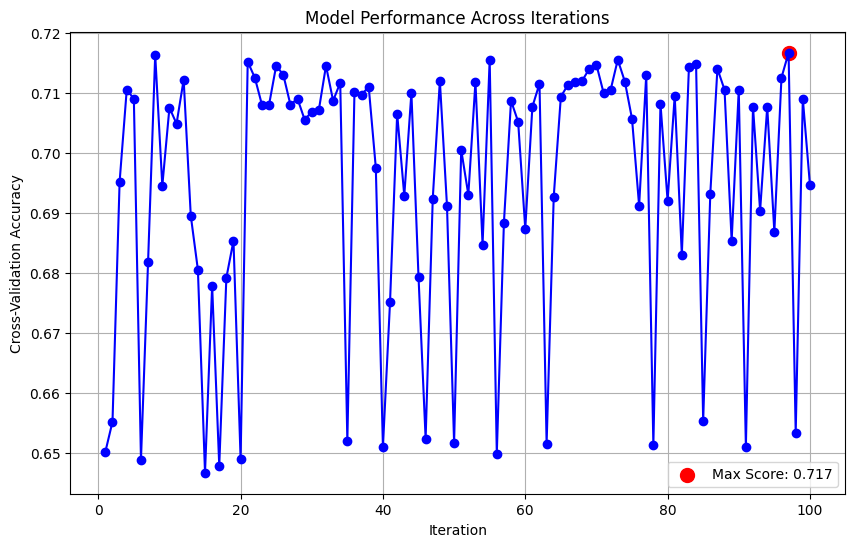

The maximum accuracy of 0.71667 was achieved at iteration 97.


In [16]:
import matplotlib.pyplot as plt

# Assume 'scores' contains the list of scores from each iteration
# Enumerate and plot scores
iterations = list(range(1, len(scores) + 1))  # Iterations (1, 2, 3, ..., len(scores))

plt.figure(figsize=(10, 6))
plt.plot(iterations, scores, marker='o', linestyle='-', color='b')
plt.title("Model Performance Across Iterations")
plt.xlabel("Iteration")
plt.ylabel("Cross-Validation Accuracy")
plt.grid(True)

# Highlight the maximum score achieved
max_score = max(scores)
max_iteration = scores.index(max_score) + 1

plt.scatter(max_iteration, max_score, color='red', s=100, label=f"Max Score: {max_score:.3f}")
plt.legend()

plt.show()

print(f"The maximum accuracy of {max_score:.5f} was achieved at iteration {max_iteration}.")

# Step 4

In [39]:
# in case of classification model:

from scipy import stats
mc_data=pd.DataFrame()
rf=RandomForestClassifier(random_state=0)
rf.fit(X_train, y_train)
y_pred_baseline = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_baseline)

rf_best = RandomForestClassifier(random_state=0, max_depth =None, min_samples_leaf=1, min_samples_split=10, n_estimators= 200) # change according to best
rf_best.fit(X_train, y_train)
y_pred_best = rf_best.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_best)

mc_data["Y_true"]=y_test.tolist()
mc_data["y_pred_baseline"]=y_pred_baseline
mc_data["y_pred_best"]=y_pred_best

contingency_table = np.zeros((2,2)).astype(int)

for index, row in mc_data.iterrows():
    y_pred_baseline = row['y_pred_baseline']
    y_pred_best = row['y_pred_best']
    y_true = row['Y_true']

    # Determine if each model is correct
    baseline_correct = (y_pred_baseline == y_true)
    best_correct = (y_pred_best == y_true)

    # Fill the contingency table
    if baseline_correct and best_correct:  # Both models are correct
        contingency_table[0, 0] += 1
    elif not baseline_correct and best_correct:
        contingency_table[0, 1] += 1
    elif baseline_correct and not best_correct:
        contingency_table[1, 0] += 1
    else:  # Both models are wrong
        contingency_table[1, 1] += 1

# Print the contingency table
print("Contingency Table:")
contingency_table

contingency_table_df=pd.DataFrame(data={"baseline_correct":['',''], "baseline_wrong":['','']}, index=["best_correct","best_wrong"])
contingency_table_df.iloc[:,:]=contingency_table
print(contingency_table_df)
'''res = stats.chi2_contingency(contingency_table_df)
print(f"Chi2 test result: {res.statistic}")
# c)
print(f"Chi2 p-value: {res.pvalue}")'''

# McNemar's Test without any continuity correction
print(mcnemar(contingency_table, exact=False))

# McNemar's Test with the continuity correction
print(mcnemar(contingency_table, exact=False, correction=False))

Contingency Table:
             baseline_correct baseline_wrong
best_correct             4040            236
best_wrong                254           1470
pvalue      0.4424980466684393
statistic   0.5897959183673469
pvalue      0.4161279849262569
statistic   0.6612244897959184


In [40]:
from scipy.stats import chi2

b = contingency_table[1, 0]  # baseline wrong, best correct
c = contingency_table[0, 1]  # baseline correct, best wrong

# McNemar's test statistic
mcnemar_stat = (abs(b - c) - 1) ** 2 / (b + c)

# Degrees of freedom
df = 1

# p-value for chi-squared distribution with 1 degree of freedom
p_value = chi2.sf(mcnemar_stat, df)

if p_value < 0.05:
    print("The difference in performance between the constructed pipeline and the baseline is statistically significant with p-value ", p_value)
else:
    # This block executes if the loop completes without hitting a `break`
    print("The difference in performance between the constructed pipeline and the baseline is not statistically significant, p-value is ", p_value)


The difference in performance between the constructed pipeline and the baseline is not statistically significant, p-value is  0.4424980466684393
